# <center><font color='Blue'>**DA4 Assignment 2: Panel practice**</font></center>
<center> Author: Enkhsaikhan Usny-Ekh

In [53]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import haversine as hs   
from haversine import Unit
import os
from skimpy import skim
import wbdata
import datetime
from linearmodels import PanelOLS


warnings.filterwarnings("ignore")

### <span style="color:blue"><b>1. Data importing and cleaning</b></span>

In [54]:
wbdata.get_sources()

  id  name
----  --------------------------------------------------------------------
   1  Doing Business
   2  World Development Indicators
   3  Worldwide Governance Indicators
   5  Subnational Malnutrition Database
   6  International Debt Statistics
  11  Africa Development Indicators
  12  Education Statistics
  13  Enterprise Surveys
  14  Gender Statistics
  15  Global Economic Monitor
  16  Health Nutrition and Population Statistics
  18  IDA Results Measurement System
  19  Millennium Development Goals
  20  Quarterly Public Sector Debt
  22  Quarterly External Debt Statistics SDDS
  23  Quarterly External Debt Statistics GDDS
  25  Jobs
  27  Global Economic Prospects
  28  Global Financial Inclusion
  29  The Atlas of Social Protection: Indicators of Resilience and Equity
  30  Exporter Dynamics Database – Indicators at Country-Year Level
  31  Country Policy and Institutional Assessment
  32  Global Financial Development
  33  G20 Financial Inclusion Indicators
  34  Glob

Searching for indicators id

In [55]:
wbdata.get_indicators(source = 2)

id                          name
--------------------------  ---------------------------------------------------------------------------------------------------------------------------------------------
AG.CON.FERT.PT.ZS           Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS              Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2              Agricultural land (sq. km)
AG.LND.AGRI.ZS              Agricultural land (% of land area)
AG.LND.ARBL.HA              Arable land (hectares)
AG.LND.ARBL.HA.PC           Arable land (hectares per person)
AG.LND.ARBL.ZS              Arable land (% of land area)
AG.LND.CREL.HA              Land under cereal production (hectares)
AG.LND.CROP.ZS              Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2           Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS           Rural land area where elevation is below 5 meters (% of total land area)
AG.LND.EL5M.UR.K2  

In [56]:
indicators = {"NY.GDP.PCAP.PP.KD":"gdppc", "EN.GHG.CO2.MT.CE.AR5":"co2_tot", "SP.POP.TOTL":"pop",
              "EN.URB.MCTY.TL.ZS":"urban", "NV.IND.TOTL.ZS":"industry", "EG.USE.COMM.GD.PP.KD":"energy", 
              "NY.GNP.PCAP.CD":"gnipc"}

df = wbdata.get_dataframe(indicators, country = "all", parse_dates = True)

In [57]:
df

gdppc   co2_tot          pop  \
country                     date                                             
Africa Eastern and Southern 2023-01-01  3967.860937  579.8655  750503764.0   
                            2022-01-01  3974.803045  588.4335  731821393.0   
                            2021-01-01  3934.287267  606.3945  713090928.0   
                            2020-01-01  3861.111238  578.0520  694446100.0   
                            2019-01-01  4073.880522  654.5401  675950189.0   
...                                             ...       ...          ...   
Zimbabwe                    1964-01-01          NaN       NaN    4320006.0   
                            1963-01-01          NaN       NaN    4185877.0   
                            1962-01-01          NaN       NaN    4055959.0   
                            1961-01-01          NaN       NaN    3930401.0   
                            1960-01-01          NaN       NaN    3809389.0   

                                            urban   industry  energy  \
country                     date                                       
Africa Eastern and Southern 2023-01-01  14.812855  25.127897     NaN   
                            2022-01-01  14.649723  26.921919     NaN   
                            2021-01-01  14.508221  26.075267     NaN   
                            2020-01-01  14.379939  25.434235     NaN   
                            2019-01-01  14.261047  26.421751     NaN   
...                                           ...        ...     ...   
Zimbabwe                    1964-01-01   7.014435        NaN     NaN   
                            1963-01-01   6.884842        NaN     NaN   
                            1962-01-01   6.758056        NaN     NaN   
                            1961-01-01   6.633038        NaN     NaN   
                            1960-01-01   6.509653        NaN     NaN   

                                              gnipc  
country                     date                     
Africa Eastern and Southern 2023-01-01  1579.924932  
                            2022-01-01  1534.027144  
                            2021-01-01  1451.609900  
                            2020-01-01  1381.202876  
                            2019-01-01  1489.693436  
...                                             ...  
Zimbabwe                    1964-01-01   180.000000  
                            1963-01-01   210.000000  
                            1962-01-01   210.000000  
                            1961-01-01          NaN  
                            1960-01-01          NaN  

[17024 rows x 7 columns]

Filtering data by country and year

In [58]:
#Filtering out rows with non-country data (e.g., continents, regions)
df = df.reset_index()
df["year"] = df["date"].dt.year

dropping = {'Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle East & North Africa (IDA & IBRD countries)',
       'Middle income', 'North America', 'Not classified', 'OECD members',
       'Other small states', 'Pacific island small states',
       'Post-demographic dividend', 'Pre-demographic dividend',
       'Small states', 'South Asia', 'South Asia (IDA & IBRD)',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income',
       'World' }

df_country = df[~df["country"].isin(dropping)]

In [59]:
#Filtering data frame with year 
df_country = df_country[df_country["year"] >= 1992]

In [60]:
df_country

,country,date,gdppc,co2_tot,pop,urban,industry,energy,gnipc,year
3136,Afghanistan,2023-01-01,1992.424394,8.7073,41454761.0,11.069093,13.523103,NaN,380.0,2023
3137,Afghanistan,2022-01-01,1981.710168,8.2599,40578842.0,10.985730,16.050368,NaN,370.0,2022
3138,Afghanistan,2021-01-01,2144.166570,7.9308,40000412.0,10.839313,14.273657,NaN,380.0,2021
3139,Afghanistan,2020-01-01,2769.685745,7.0541,39068979.0,10.805330,12.952600,NaN,490.0,2020
3140,Afghanistan,2019-01-01,2927.245144,7.2491,37856121.0,10.867542,14.058112,NaN,520.0,2019
...,...,...,...,...,...,...,...,...,...,...
16987,Zimbabwe,1996-01-01,4271.479930,15.7173,11158360.0,11.462948,23.002386,205.606308,560.0,1996
16988,Zimbabwe,1995-01-01,3935.280057,16.2660,10974599.0,11.436919,25.700235,227.866804,470.0,1995
16989,Zimbabwe,1994-01-01,3965.730986,16.5485,10873148.0,11.328035,29.152941,224.166895,490.0,1994
16990,Zimbabwe,1993-01-01,3634.750494,17.6722,10860288.0,11.129631,30.463030,246.637918,510.0,1993


Droping missing values

In [61]:
#Counting missing values
df_country.isna().sum()


country        0
date           0
gdppc        728
co2_tot      448
pop            0
urban       3072
industry    1023
energy      3752
gnipc        728
year           0
dtype: int64

In [62]:
#Dropping rows if gdp per capita and co missing
df_country = df_country.dropna(subset=["gdppc", "co2_tot"])

In [63]:
df_country.isna().sum()

country        0
date           0
gdppc          0
co2_tot        0
pop            0
urban       2315
industry     472
energy      2877
gnipc        106
year           0
dtype: int64

In [64]:
#Number of country used in the analysis
df_country["country"].nunique()

191

In [65]:
df.to_csv("data.csv", index=False)

In [66]:
#Dropping rows if gdp and co2 is less than or equal to zero 
df_country = df_country[df_country["gdppc"] >0] 
df_country = df_country[df_country["co2_tot"] > 0]

Converting variables into logs, square, and per capita

In [67]:
df_country["co2pc"] = (df_country["co2_tot"]*1000000)/df_country["pop"]
df_country["lgdppc"] = np.log(df_country["gdppc"])
df_country["gdpsq"] = np.log(df_country["gdppc"])
df_country["lenergy"]= np.log(df_country["energy"])

df_country["lco2pc"] = np.log(df_country["co2pc"])

In [68]:
df_country

,country,date,gdppc,co2_tot,pop,urban,industry,energy,gnipc,year,co2pc,lgdppc,gdpsq,lenergy,lco2pc
3136,Afghanistan,2023-01-01,1992.424394,8.7073,41454761.0,11.069093,13.523103,NaN,380.0,2023,0.210043,7.597107,7.597107,NaN,-1.560441
3137,Afghanistan,2022-01-01,1981.710168,8.2599,40578842.0,10.985730,16.050368,NaN,370.0,2022,0.203552,7.591715,7.591715,NaN,-1.591834
3138,Afghanistan,2021-01-01,2144.166570,7.9308,40000412.0,10.839313,14.273657,NaN,380.0,2021,0.198268,7.670506,7.670506,NaN,-1.618136
3139,Afghanistan,2020-01-01,2769.685745,7.0541,39068979.0,10.805330,12.952600,NaN,490.0,2020,0.180555,7.926489,7.926489,NaN,-1.711720
3140,Afghanistan,2019-01-01,2927.245144,7.2491,37856121.0,10.867542,14.058112,NaN,520.0,2019,0.191491,7.981817,7.981817,NaN,-1.652915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16987,Zimbabwe,1996-01-01,4271.479930,15.7173,11158360.0,11.462948,23.002386,205.606308,560.0,1996,1.408567,8.359716,8.359716,5.325963,0.342573
16988,Zimbabwe,1995-01-01,3935.280057,16.2660,10974599.0,11.436919,25.700235,227.866804,470.0,1995,1.482150,8.277737,8.277737,5.428761,0.393494
16989,Zimbabwe,1994-01-01,3965.730986,16.5485,10873148.0,11.328035,29.152941,224.166895,490.0,1994,1.521960,8.285445,8.285445,5.412391,0.419999
16990,Zimbabwe,1993-01-01,3634.750494,17.6722,10860288.0,11.129631,30.463030,246.637918,510.0,1993,1.627231,8.198296,8.198296,5.507921,0.486880


Balancing panel data

In [69]:
df_country["balanced"] = df_country["country"].isin(
    df_country.groupby("country")
    .agg(
        min_year=("year", min), max_year=("year", max), n_unique_years=("year", "count")
    )
    .query("(min_year == 1992)&(max_year == 2023)&(n_unique_years==32)")
    .index
)


In [70]:
df_country.balanced.value_counts()

balanced
True     5632
False     265
Name: count, dtype: int64

In [71]:
data_balanced = df_country.query("balanced == True")

In [72]:
data_balanced

,country,date,gdppc,co2_tot,pop,urban,industry,energy,gnipc,year,co2pc,lgdppc,gdpsq,lenergy,lco2pc,balanced
3200,Albania,2023-01-01,17975.798395,4.5918,2745972.0,NaN,23.018472,NaN,7680.0,2023,1.672195,9.796782,9.796782,NaN,0.514137,True
3201,Albania,2022-01-01,17097.478360,4.6090,2777689.0,NaN,23.025058,NaN,6820.0,2022,1.659293,9.746686,9.746686,NaN,0.506392,True
3202,Albania,2021-01-01,16113.136519,5.0393,2811666.0,NaN,22.434115,NaN,6150.0,2021,1.792283,9.687390,9.687390,NaN,0.583490,True
3203,Albania,2020-01-01,14650.395929,4.5608,2837849.0,NaN,23.468716,NaN,5320.0,2020,1.607133,9.592223,9.592223,NaN,0.474452,True
3204,Albania,2019-01-01,15065.749573,4.9535,2854191.0,NaN,22.965531,NaN,5280.0,2019,1.735518,9.620179,9.620179,NaN,0.551306,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16987,Zimbabwe,1996-01-01,4271.479930,15.7173,11158360.0,11.462948,23.002386,205.606308,560.0,1996,1.408567,8.359716,8.359716,5.325963,0.342573,True
16988,Zimbabwe,1995-01-01,3935.280057,16.2660,10974599.0,11.436919,25.700235,227.866804,470.0,1995,1.482150,8.277737,8.277737,5.428761,0.393494,True
16989,Zimbabwe,1994-01-01,3965.730986,16.5485,10873148.0,11.328035,29.152941,224.166895,490.0,1994,1.521960,8.285445,8.285445,5.412391,0.419999,True
16990,Zimbabwe,1993-01-01,3634.750494,17.6722,10860288.0,11.129631,30.463030,246.637918,510.0,1993,1.627231,8.198296,8.198296,5.507921,0.486880,True


In [73]:
#Taking the first difference
countries_grouped = data_balanced.groupby("country")

data_balanced["d_lgdppc"] = countries_grouped["lgdppc"].transform("diff")
data_balanced["d_lco2pc"] = countries_grouped["lco2pc"].transform("diff")
data_balanced["d_lenergy"] = countries_grouped["lenergy"].transform("diff")
data_balanced["d_industry"] = countries_grouped["industry"].transform("diff")
data_balanced["d_urban"] = countries_grouped["urban"].transform("diff")


data_balanced = data_balanced.sort_values(by=["country", "year"])



In [74]:
data_balanced = pd.DataFrame(data_balanced)

### <span style="color:blue"><b>2. Descriptive analysis and visualization </b></span>

In [75]:
data_balanced

,country,date,gdppc,co2_tot,pop,urban,industry,energy,gnipc,year,...,lgdppc,gdpsq,lenergy,lco2pc,balanced,d_lgdppc,d_lco2pc,d_lenergy,d_industry,d_urban
3231,Albania,1992-01-01,3603.488845,2.3630,3247039.0,NaN,NaN,116.078236,280.0,1992,...,8.189658,8.189658,4.754264,-0.317812,True,-0.097398,0.055108,0.111623,NaN,NaN
3230,Albania,1993-01-01,3972.123929,2.2227,3227287.0,NaN,NaN,103.818231,320.0,1993,...,8.287056,8.287056,4.642642,-0.372919,True,-0.085900,-0.059318,0.018233,NaN,NaN
3229,Albania,1994-01-01,4328.413978,2.3441,3207536.0,NaN,NaN,101.942489,380.0,1994,...,8.372956,8.372956,4.624409,-0.313602,True,-0.131243,0.118176,0.187683,NaN,NaN
3228,Albania,1995-01-01,4935.452220,2.0700,3187784.0,NaN,NaN,84.497798,640.0,1995,...,8.504200,8.504200,4.436725,-0.431777,True,-0.093310,0.001106,0.022024,NaN,NaN
3227,Albania,1996-01-01,5418.148325,2.0549,3168033.0,NaN,17.373841,82.657182,890.0,1996,...,8.597509,8.597509,4.414702,-0.432884,True,0.109381,0.256232,0.042884,-0.735925,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16964,Zimbabwe,2019-01-01,3294.806084,11.1692,15271368.0,9.961851,32.025947,NaN,2170.0,2019,...,8.100103,8.100103,NaN,-0.312820,True,0.097987,0.224550,NaN,-0.741570,0.108493
16963,Zimbabwe,2020-01-01,2987.269823,9.0721,15526888.0,9.853359,32.767517,NaN,1690.0,2020,...,8.002115,8.002115,NaN,-0.537369,True,-0.064025,-0.140586,NaN,3.961930,0.093256
16962,Zimbabwe,2021-01-01,3184.785451,10.6233,15797210.0,9.760103,28.805586,NaN,1740.0,2021,...,8.066140,8.066140,NaN,-0.396784,True,-0.042520,-0.014414,NaN,-10.886055,0.066068
16961,Zimbabwe,2022-01-01,3323.121932,10.9630,16069056.0,9.694036,39.691642,NaN,1960.0,2022,...,8.108660,8.108660,NaN,-0.382369,True,-0.035221,-0.052054,NaN,13.390582,0.036455


In [76]:
data_balanced[["co2_tot", "co2pc", "gdppc", "energy", "urban", "industry"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
co2_tot,5632.0,167.83,776.06,0.00,2.17,10.84,65.86,13259.64
co2pc,5632.0,5.24,9.98,0.00,0.62,2.41,6.68,202.87
gdppc,5632.0,21753.17,24157.68,510.82,4281.40,12839.93,31776.89,174339.08
energy,3082.0,125.37,96.09,3.94,72.21,96.83,141.30,858.43
urban,3616.0,24.78,17.84,2.14,12.63,19.51,29.70,100.00
industry,5250.0,26.95,12.15,2.82,19.44,25.12,32.01,86.67


Text(0.5, 1.0, 'Log of CO2 per capita')

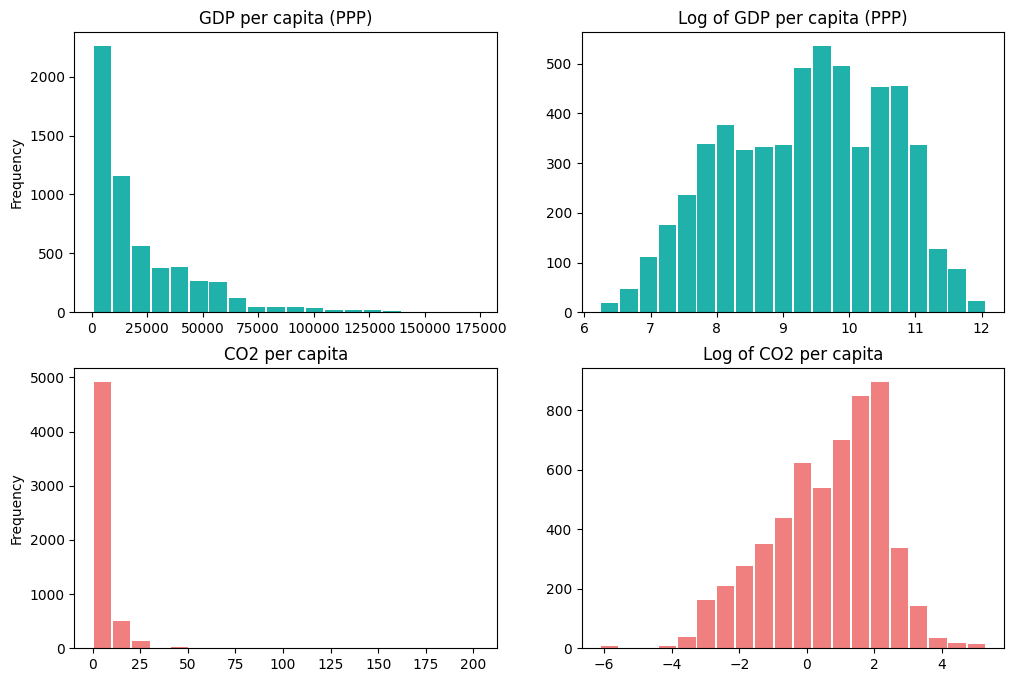

In [77]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))

ax[0, 0].hist(data_balanced.gdppc, bins = 20, rwidth = 0.9, color = "lightseagreen")
ax[0, 0].set_title("GDP per capita (PPP)")
ax[0, 0].set_ylabel("Frequency")

ax[0, 1].hist(data_balanced.lgdppc, bins=20, rwidth = 0.9, color = "lightseagreen")
ax[0, 1].set_title("Log of GDP per capita (PPP)")

ax[1, 0].hist(data_balanced.co2pc, bins=20, rwidth = 0.9, color = "lightcoral")
ax[1, 0].set_title("CO2 per capita")
ax[1, 0].set_ylabel("Frequency")

ax[1, 1].hist(data_balanced.lco2pc, bins=20, rwidth = 0.9, color = "lightcoral")
ax[1, 1].set_title("Log of CO2 per capita")

World emission of CO2

In [78]:
df_world = df[df["country"] == "World"]
df_world["co2pc"] = (df_world["co2_tot"]/df_world["pop"])*1000000

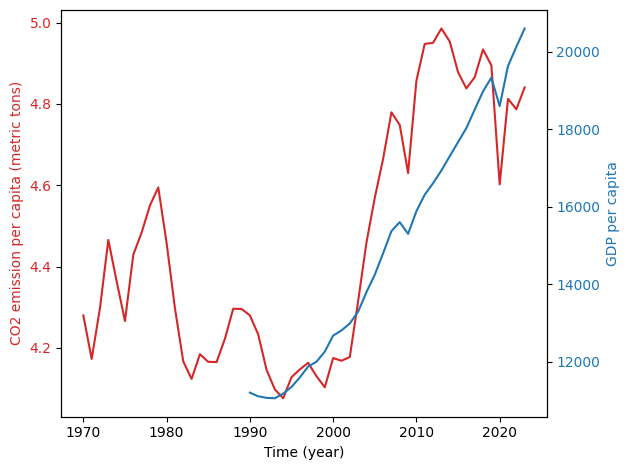

In [79]:
fig, ax1 = plt.subplots()

color="tab:red"
ax1.set_xlabel("Time (year)")
ax1.set_ylabel("CO2 emission per capita (metric tons)", color = color)
ax1.plot(df_world.year, df_world.co2pc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("GDP per capita", color=color)
ax2.plot(df_world.year, df_world.gdppc, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()


In [80]:
df["co2pc"] = (df["co2_tot"]/df["pop"])*1000000

In [81]:
high = df[(df["country"] == "High income")]
up_middle = df[(df["country"] == "Upper middle income")]
low_middle = df[(df["country"] == "Lower middle income")]
low = df[(df["country"] == "Low income")]

Text(2010, 0.6, 'Low income')

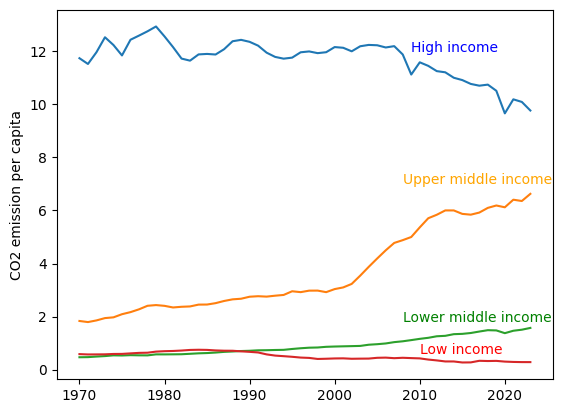

In [82]:
fig, ax = plt.subplots()

ax.plot(high.year, high.co2pc)
ax.plot(up_middle.year, up_middle.co2pc)
ax.plot(low_middle.year, low_middle.co2pc)
ax.plot(low.year, low.co2pc)
ax.set_ylabel("CO2 emission per capita")

ax.text(2009, 12, "High income", color = "blue")
ax.text(2008, 7, "Upper middle income", color = "orange")
ax.text(2008, 1.8, "Lower middle income", color = "green")
ax.text(2010, 0.6, "Low income", color = "red")

<Axes: xlabel='lgdppc', ylabel='lco2pc'>

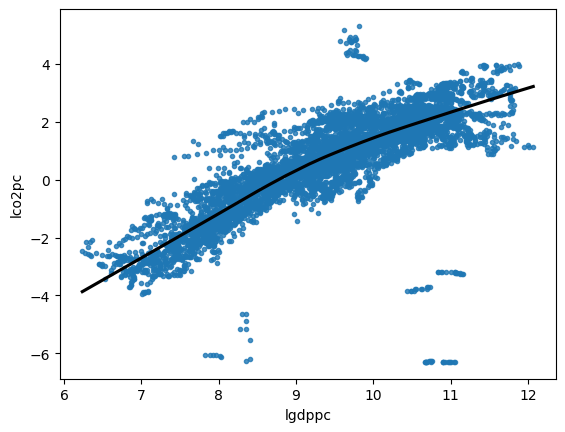

In [83]:
sns.regplot(
    data = df_country, x = "lgdppc", y="lco2pc",
    marker = ".",
    fit_reg = True, lowess= True,
    line_kws = {"color":"k"}
)

### <span style="color:blue"><b>3. Regression analysis</b></span>

##### 1. Cross section

2005

In [84]:
data_2005 = data_balanced[data_balanced["year"] == 2005]

In [85]:
data_2005["country"] = data_2005["country"].astype("category")

In [86]:
reg_2005 = smf.ols("lco2pc ~ lgdppc", data=data_2005).fit(cov_type="HC1")
print(reg_2005.summary())

                            OLS Regression Results                            
Dep. Variable:                 lco2pc   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     722.5
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           7.62e-64
Time:                        21:53:02   Log-Likelihood:                -198.75
No. Observations:                 176   AIC:                             401.5
Df Residuals:                     174   BIC:                             407.8
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.7867      0.427    -25.271      0.0

2005 with confounders

In [87]:
reg_2005_conf = smf.ols("lco2pc ~ lgdppc + lenergy + industry", data=data_2005).fit(cov_type="HC1")
print(reg_2005.summary())

                            OLS Regression Results                            
Dep. Variable:                 lco2pc   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     722.5
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           7.62e-64
Time:                        21:53:02   Log-Likelihood:                -198.75
No. Observations:                 176   AIC:                             401.5
Df Residuals:                     174   BIC:                             407.8
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.7867      0.427    -25.271      0.0

2023

In [88]:
data_2023 = data_balanced[data_balanced["year"] == 2023]

In [89]:
reg_2023 = smf.ols("lco2pc ~ lgdppc", data=data_2023).fit(cov_type="HC1")
print(reg_2023.summary())

                            OLS Regression Results                            
Dep. Variable:                 lco2pc   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     591.7
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           7.13e-58
Time:                        21:53:02   Log-Likelihood:                -180.76
No. Observations:                 176   AIC:                             365.5
Df Residuals:                     174   BIC:                             371.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.4976      0.421    -22.561      0.0

In [90]:
table1 = Stargazer([reg_2005, reg_2005_conf, reg_2023])
table1.custom_columns(["2005", "2005 with confounders", "2023"], [1, 1, 1])
table1

#### 2. First difference model

No lags

In [91]:
model = smf.ols("d_lco2pc ~ d_lgdppc.shift(0) + C(year) + C(country)", data_balanced)

fd_nol = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "country"]}
)
 
fd_nol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               d_lco2pc   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     12.68
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           1.35e-30
Time:                        21:53:03   Log-Likelihood:                 3901.2
No. Observations:                5456   AIC:                            -7388.
Df Residuals:                    5249   BIC:                            -6021.
Df Model:                         206                                         
Covariance Type:              cluster                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.0079      0.009      0.832      0.405      -0.011       0.026
C(year)[T.1993]                                 -0.0403      0.022     -1.847      0.065      -0.083       0.002
C(year)[T.1994]                                 -0.0217      0.013     -1.638      0.101      -0.048       0.004
C(year)[T.1995]                                 -0.0217      0.012     -1.867      0.062      -0.044       0.001
C(year)[T.1996]                                 -0.0215      0.013     -1.687      0.092      -0.046       0.003
C(year)[T.1997]                                 -0.0361      0.025     -1.461      0.144      -0.085       0.012
C(year)[T.1998]                                 -0.0115      0.013     -0.897      0.370      -0.037       0.014
C(year)[T.1999]                                 -0.0272      0.019     -1.432      0.152      -0.064       0.010
C(year)[T.2000]                                 -0.0172      0.010     -1.680      0.093      -0.037       0.003
C(year)[T.2001]                                 -0.0041      0.012     -0.344      0.731      -0.028       0.019
C(year)[T.2002]                                 -0.0403      0.013     -3.099      0.002      -0.066      -0.015
C(year)[T.2003]                                 -0.0189      0.012     -1.537      0.124      -0.043       0.005
C(year)[T.2004]                                 -0.0137      0.011     -1.206      0.228      -0.036       0.009
C(year)[T.2005]                                 -0.0217      0.011     -1.933      0.053      -0.044       0.000
C(year)[T.2006]                                 -0.0187      0.011     -1.636      0.102      -0.041       0.004
C(year)[T.2007]                                  0.0055      0.012      0.474      0.635      -0.017       0.028
C(year)[T.2008]                                 -0.0023      0.012     -0.188      0.851      -0.026       0.021
C(year)[T.2009]                                 -0.0384      0.010     -3.846      0.000      -0.058      -0.019
C(year)[T.2010]                                 -0.0006      0.014     -0.040      0.968      -0.028       0.027
C(year)[T.2011]                                 -0.0252      0.013     -1.880      0.060      -0.051       0.001
C(year)[T.2012]                                 -0.0110      0.011     -0.969      0.332      -0.033       0.011
C(year)[T.2013]                                 -0.0145      0.011     -1.336      0.182      -0.036       0.007
C(year)[T.2014]                                 -0.0171      0.012     -1.408      0.159      -0.041       0.007
C(year)[T.2015]                                 -0.0262      0.011     -2.398      0.017      -0.048      -0.005
C(year)[T.2016]                 

2 years lags

In [92]:
model = smf.ols("d_lco2pc ~ d_lgdppc.shift(0) + d_lgdppc.shift(1) + d_lgdppc.shift(2) + C(year) + C(country)", data_balanced)

fd_2 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "country"]}
)

2 years lag with confounders

In [93]:
model = smf.ols("d_lco2pc ~ d_lgdppc.shift(0) + d_lgdppc.shift(1) + d_lgdppc.shift(2)\
                + d_lenergy.shift(0) + d_lenergy.shift(1) + d_lenergy.shift(2)\
                + d_industry.shift(0) + d_industry.shift(1) + d_industry.shift(2) + C(year) + C(country)", data_balanced)

fd_2_c = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "country"]}
)

6 years lags

In [94]:
model = smf.ols("d_lco2pc ~ d_lgdppc.shift(0) + d_lgdppc.shift(1) + d_lgdppc.shift(2)\
                + d_lgdppc.shift(3) + d_lgdppc.shift(4) + d_lgdppc.shift(5)\
                + d_lgdppc.shift(6) + C(year) + C(country)", data_balanced)

fd_6 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "country"]}
)

Combining results

In [95]:
table2 = Stargazer([fd_nol, fd_2, fd_6, fd_2_c])
table2.covariate_order(
    [
        "d_lgdppc.shift(0)",
        "d_lgdppc.shift(1)",
        "d_lgdppc.shift(2)",
        "d_lgdppc.shift(3)",
        "d_lgdppc.shift(4)",
        "d_lgdppc.shift(5)",
        "d_lgdppc.shift(6)",
        "d_lenergy.shift(0)",
        "d_lenergy.shift(1)",
        "d_lenergy.shift(2)",
        "d_industry.shift(0)",
        "d_industry.shift(1)",
        "d_industry.shift(2)",
        "Intercept"
    ]
)
table2.rename_covariates({"Intercept": "Constant"})
table2.add_line("Year dummies", ["Yes", "Yes", "Yes", "Yes"])
table2.add_line("Country-specific trends", ["Yes", "Yes", "Yes", "Yes"])
table2

#### 3. Fixed effects model

In [96]:
data_balanced = pd.DataFrame(data_balanced)

In [97]:
data_balanced = data_balanced.assign(
    Year=lambda x: x["year"].astype("category")
).set_index(["country", "year"])

In [98]:
type(data_balanced)

pandas.core.frame.DataFrame

In [99]:
fe_1 = PanelOLS.from_formula(
    "lco2pc ~ lgdppc",
    data_balanced
).fit(cov_type="clustered", cluster_entity=True)

In [100]:
fe_2 = PanelOLS.from_formula(
    "lco2pc ~ lgdppc + Year",
    data_balanced
).fit(cov_type="clustered", cluster_entity=True)

In [101]:
fe_3 = PanelOLS.from_formula(
    "lco2pc ~ lgdppc + EntityEffects",
    data_balanced
).fit(cov_type="clustered", cluster_entity=True)

In [102]:
fe_4 = PanelOLS.from_formula(
    "lco2pc ~ lgdppc + Year + EntityEffects",
    data_balanced
).fit(cov_type="clustered", cluster_entity=True)

fe_3

Dep. Variable:,lco2pc,R-squared:,0.2362
Estimator:,PanelOLS,R-squared (Between):,-8.2803
No. Observations:,5632,R-squared (Within):,0.2362
Date:,"Sun, Feb 16 2025",R-squared (Overall):,-7.9449
Time:,21:53:04,Log-likelihood,-1310.2
Cov. Estimator:,Clustered,,
,,F-statistic:,1686.6
Entities:,176,P-value,0.0000
Avg Obs:,32.000,Distribution:,"F(1,5455)"
Min Obs:,32.000,,
Max Obs:,32.000,F-statistic (robust):,76.419


In [103]:
table3 = Stargazer([fe_1, fe_2, fe_3, fe_4])
table3.covariate_order(
    [
        "lgdppc", 
    ]
)
table3.rename_covariates({"Intercept": "Constant"})
table3.add_line("Year fixed effect", ["No", "Yes", "No", "Yes"])
table3.add_line("Country fixed effect", ["No", "No", "Yes", "Yes"])
table3